<a href="https://colab.research.google.com/github/vegansam/AI4CCEE_Fall_2024/blob/main/mini_project/MiniProject_1/Submission/SamGood_MiniProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import os

This section uses the ACC_AUX and accident csv's provided by the FARS database to identify fatalaties associated with crashes on arterials in Iowa. Data is sourced from 2018-2022 (5 years). This combines steps 1 and 2. To identify the arterial roads, I used the A_ROADFC variable in the ACC_AUX dataset. To identify fatalities (updated from the initial pedestrian fatalities assigned) I used the FATALS variable of the ACC_AUX database.


In [27]:
base_path = '/content/drive/MyDrive/MiniProject1Data'

# Initialize an empty list to store DataFrames for each year
all_years_data = []

for year_folder in os.listdir(base_path):
    year_path = os.path.join(base_path, year_folder)
    if os.path.isdir(year_path):

        # Read ACC_AUX.csv and filter
        acc_aux_path = os.path.join(year_path, 'ACC_AUX.CSV')
        acc_aux_df = pd.read_csv(acc_aux_path)
        filtered_acc_aux = acc_aux_df[(acc_aux_df['STATE'] == 19) & (acc_aux_df['A_ROADFC'] < 5)]

        # Read accident.csv
        accident_path = os.path.join(year_path, 'accident.csv')
        accident_df = pd.read_csv(accident_path, encoding='ISO-8859-1')

        # Merge the two DataFrames based on ST_CASE
        merged_df = pd.merge(accident_df, filtered_acc_aux, on='ST_CASE', how='inner')

        # Append the merged DataFrame to the list
        all_years_data.append(merged_df)

# Concatenate all DataFrames into one final DataFrame
final_df = pd.concat(all_years_data, ignore_index=True)

# Define the file path where you want to save the CSV in Google Drive
file_path = '/content/drive/My Drive/MiniProject1Data/final_df.csv'

# Save the final DataFrame as a CSV file
final_df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")




<ipython-input-27-bde8fff0f186>:17: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_df = pd.read_csv(accident_path, encoding='ISO-8859-1')


DataFrame saved to /content/drive/My Drive/MiniProject1Data/final_df.csv


Next, I was looking to visualize the data points on a map, so I plotted them using folium based on latitude and longitude. This wasn't a particular step of the assignment, I just wanted to check to see what the output looked like.

In [8]:
import folium

In [9]:
# Calculate the center of the map
center_lat = final_df['LATITUDE'].mean()
center_lon = final_df['LONGITUD'].mean()

# Create the map centered on the average latitude and longitude
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Iterate through the DataFrame to add smaller CircleMarkers
for index, row in final_df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUD']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_map)

# Display the map
display(my_map)


For step 3, I first applied kernel density estimation. Using kernel density estimation, it was clear to see Des Moines was a hotspot, followed by Cedar Rapids and Davenport.

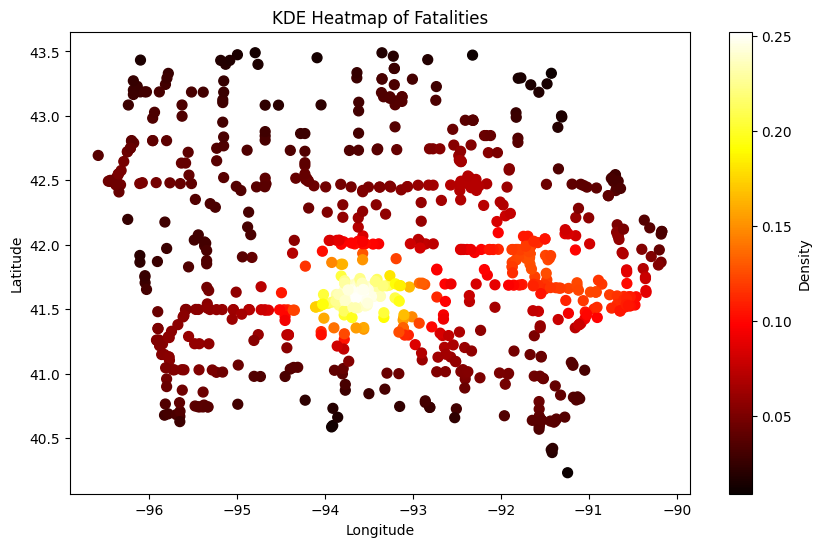

In [10]:
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create a GeoDataFrame from the lat/lon values
geometry = gpd.points_from_xy(final_df['LONGITUD'], final_df['LATITUDE'])
geo_df = gpd.GeoDataFrame(final_df, geometry=geometry)

# Extract latitudes and longitudes
x = final_df['LONGITUD']
y = final_df['LATITUDE']

# Perform Kernel Density Estimation (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)

# Plot the data with the density estimate (hotspot visualization)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=kde, s=50, cmap='hot')
plt.colorbar(label='Density')
plt.title('KDE Heatmap of Fatalities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


For step 4, I began by quantifying the crash count to ensure my visually identified hotspots were correct. This confirmed Des Moines, Davenport, and Cedar Rapids were the cities with the highest numbers of crashes associated with fatalities. Then, I read through the column names of my dataset, along with the FARS manual (to help understand variable names), and I plotted the following variables for further investigation: day of the week, year, caues of crash, intersection type, time of day and weather conditions. I graphed each city separately, to try to understand why Des Moines might have more crashes than the other two cities (besides having a larger population).

In [ ]:
# Group by CITYNAME and get the count of crashes per city
city_crash_counts = final_df.groupby('CITYNAME').size().reset_index(name='Crash_Count')

# Sort the cities by the number of crashes in descending order
sorted_city_crash_counts = city_crash_counts.sort_values(by='Crash_Count', ascending=False)

# Display the sorted result
print(sorted_city_crash_counts)


           CITYNAME  Crash_Count
50   NOT APPLICABLE          407
21       DES MOINES           39
18        DAVENPORT           28
9      CEDAR RAPIDS           21
59       SIOUX CITY           13
..              ...          ...
45    MITCHELLVILLE            1
46   MOUNT PLEASANT            1
17          CRESTON            1
48           NEVADA            1
71  WINDSOR HEIGHTS            1

[72 rows x 2 columns]


<ipython-input-12-3d5483826c6e>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=crash_counts, x='DAY_WEEKNAME', y='FATALITY_COUNT', hue='CITYNAME', order=day_order, ci=None)


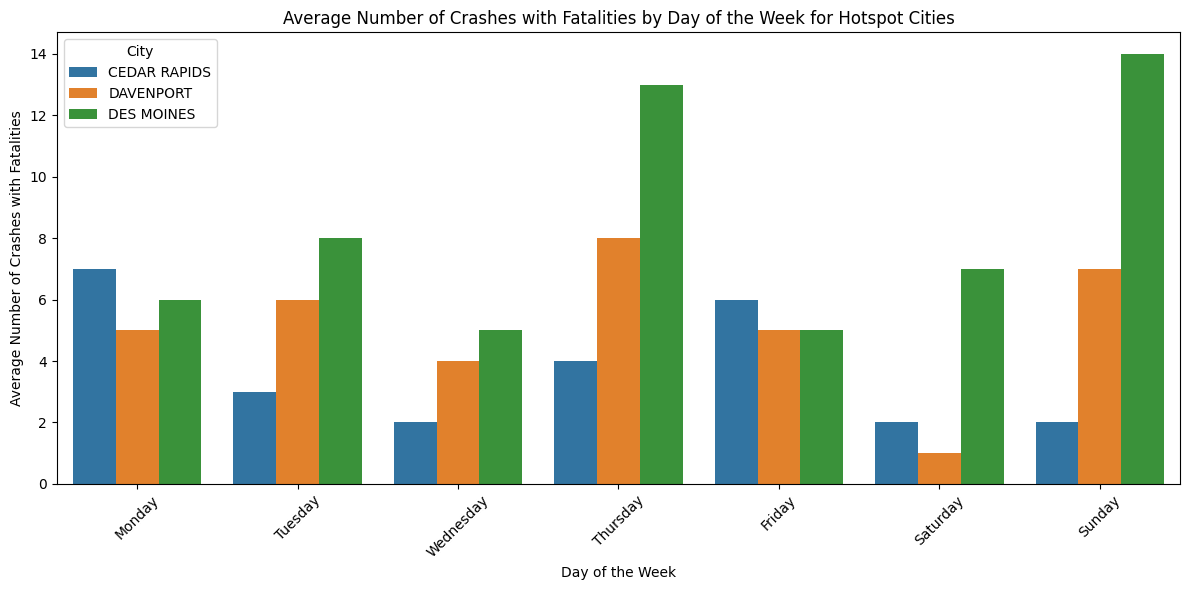

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each day of the week
crash_counts = filtered_df.groupby(['DAY_WEEKNAME', 'CITYNAME']).size().reset_index(name='FATALITY_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the bar plot with ordered days of the week
sns.barplot(data=crash_counts, x='DAY_WEEKNAME', y='FATALITY_COUNT', hue='CITYNAME', order=day_order, ci=None)

# Customize the plot
plt.title('Average Number of Crashes with Fatalities by Day of the Week for Hotspot Cities')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Crashes with Fatalities')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-13-3bf8c0e9d470>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=crash_counts, x='YEAR_x', y='FATALITY_COUNT', hue='CITYNAME', ci=None)


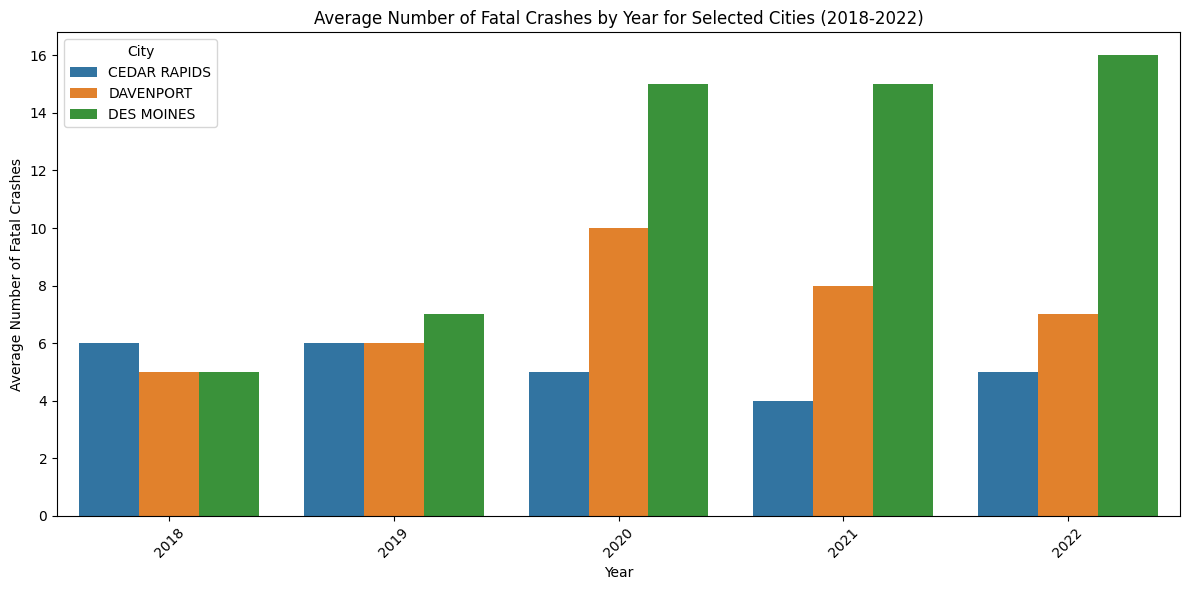

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each year
crash_counts = filtered_df.groupby(['YEAR_x', 'CITYNAME']).size().reset_index(name='FATALITY_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=crash_counts, x='YEAR_x', y='FATALITY_COUNT', hue='CITYNAME', ci=None)

# Customize the plot
plt.title('Average Number of Fatal Crashes by Year for Selected Cities (2018-2022)')
plt.xlabel('Year')
plt.ylabel('Average Number of Fatal Crashes')
plt.xticks(rotation=45)
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()



<ipython-input-14-78528f12ee0e>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=harm_event_counts, x='HARM_EVNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)


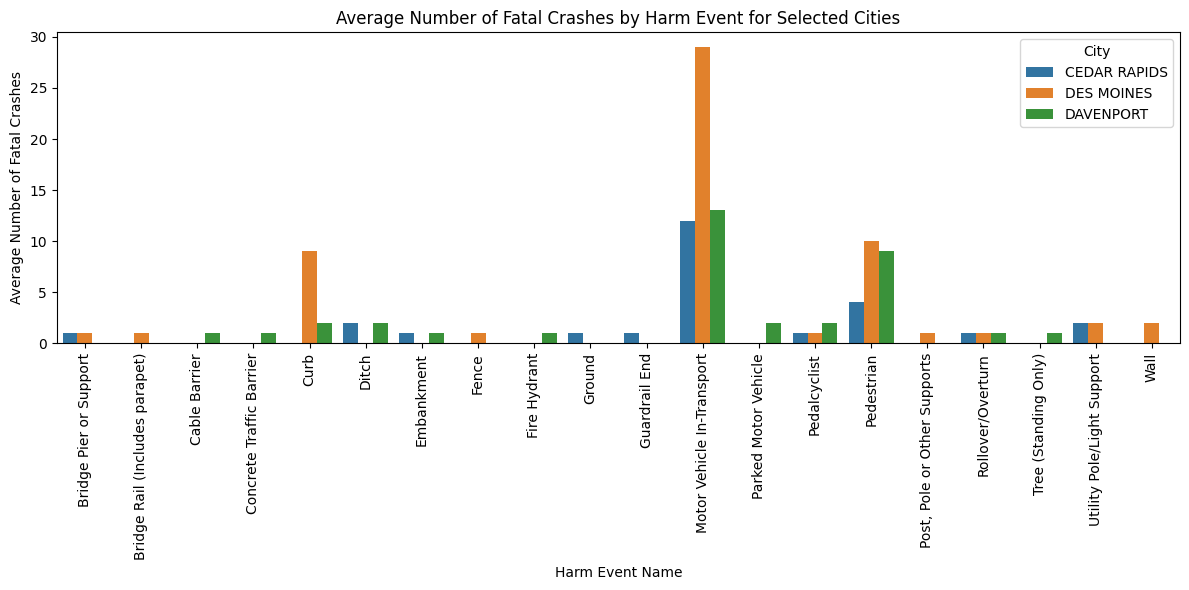

In [14]:
# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each harm event
harm_event_counts = filtered_df.groupby(['HARM_EVNAME', 'CITYNAME']).size().reset_index(name='CRASH_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=harm_event_counts, x='HARM_EVNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)

# Customize the plot
plt.title('Average Number of Fatal Crashes by Harm Event for Selected Cities')
plt.xlabel('Harm Event Name')
plt.ylabel('Average Number of Fatal Crashes')
plt.xticks(rotation=90)
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-77-695426e36265>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=intersection_counts, x='TYP_INTNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

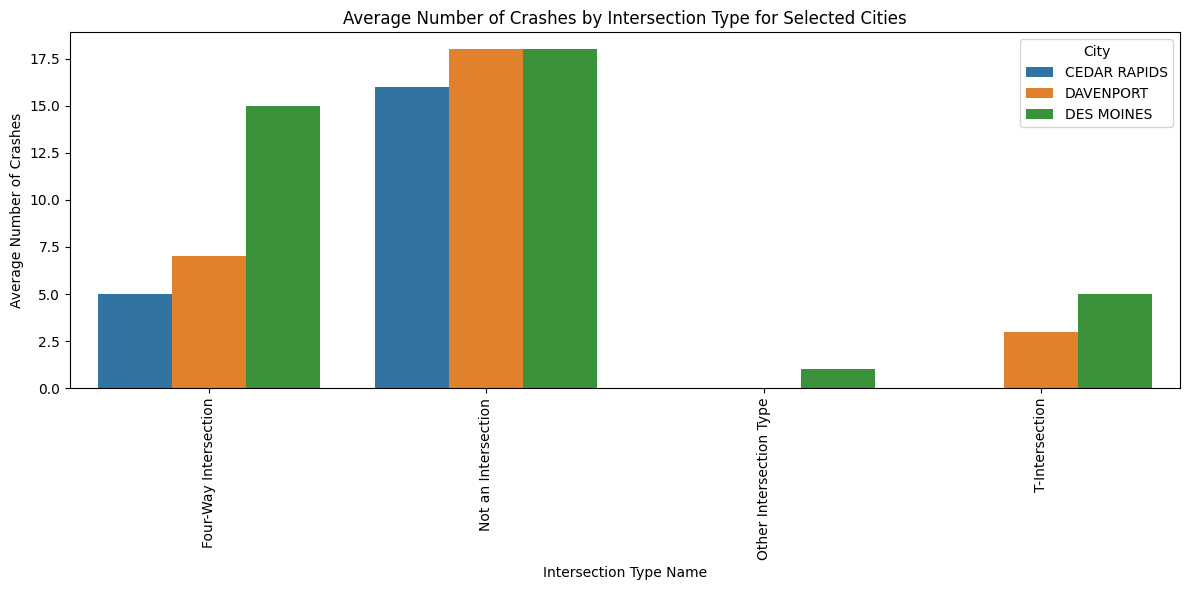

In [ ]:


# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each intersection type
intersection_counts = filtered_df.groupby(['TYP_INTNAME', 'CITYNAME']).size().reset_index(name='CRASH_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=intersection_counts, x='TYP_INTNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)

# Customize the plot
plt.title('Average Number of Crashes by Intersection Type for Selected Cities')
plt.xlabel('Intersection Type Name')
plt.ylabel('Average Number of Crashes')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-79-c0d1ff10ad61>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=light_condition_counts, x='LGT_CONDNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple

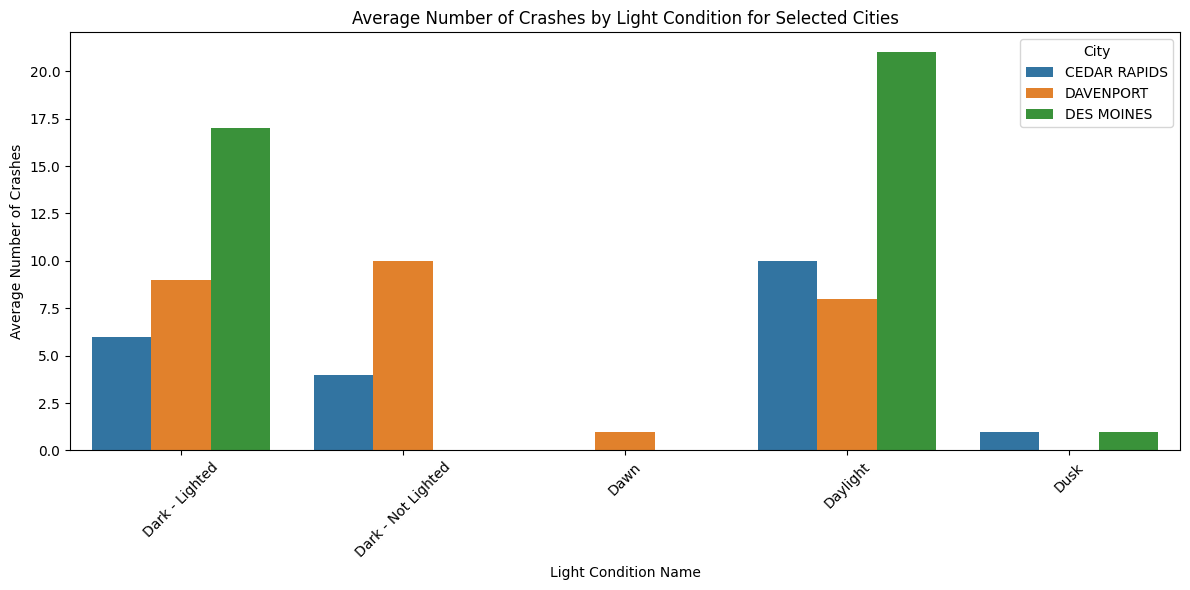

In [ ]:
# Sample DataFrame creation (use your actual final_df instead)
# final_df = pd.read_csv('your_data.csv')  # Load your data if it's not already in final_df

# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each light condition
light_condition_counts = filtered_df.groupby(['LGT_CONDNAME', 'CITYNAME']).size().reset_index(name='CRASH_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=light_condition_counts, x='LGT_CONDNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)

# Customize the plot
plt.title('Average Number of Crashes by Light Condition for Selected Cities')
plt.xlabel('Light Condition Name')
plt.ylabel('Average Number of Crashes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-26-495fc98cf8fb>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=weather_condition_counts, x='WEATHERNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)


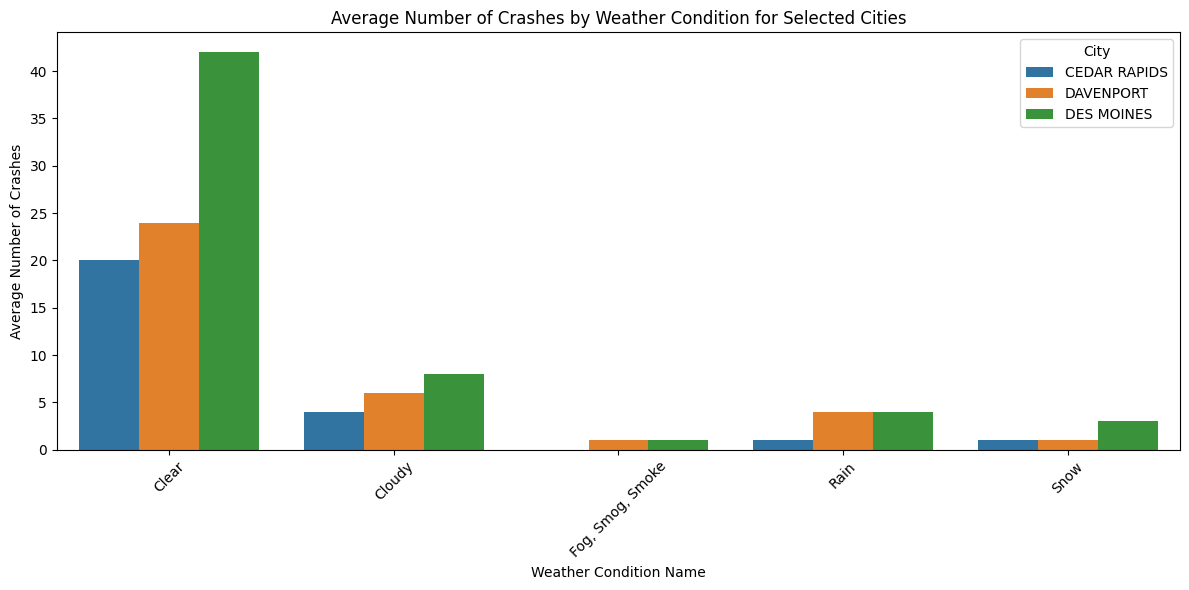

In [26]:


# Filter the DataFrame for the cities of interest
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]

# Create a count of crashes for each weather condition
weather_condition_counts = filtered_df.groupby(['WEATHERNAME', 'CITYNAME']).size().reset_index(name='CRASH_COUNT')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=weather_condition_counts, x='WEATHERNAME', y='CRASH_COUNT', hue='CITYNAME', ci=None)

# Customize the plot
plt.title('Average Number of Crashes by Weather Condition for Selected Cities')
plt.xlabel('Weather Condition Name')
plt.ylabel('Average Number of Crashes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


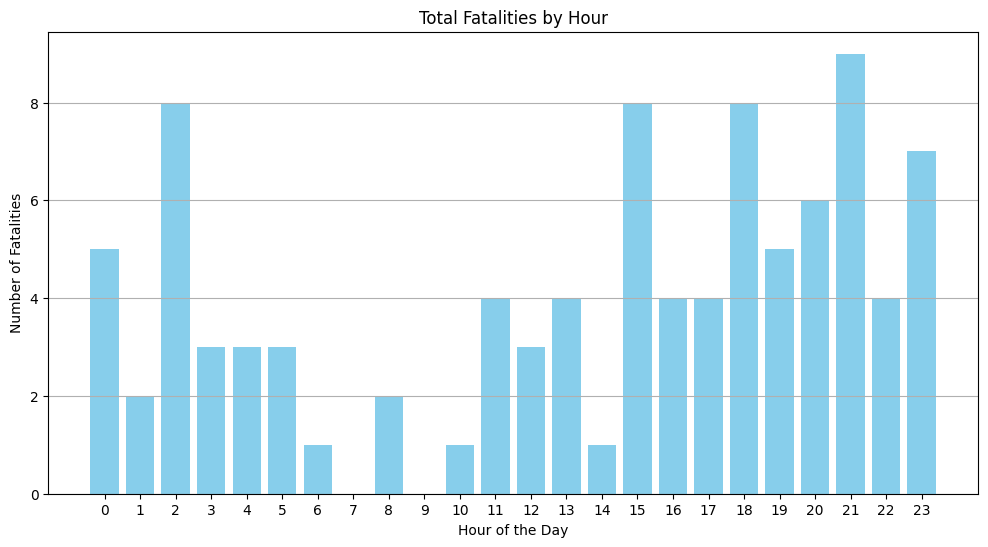

In [ ]:
import matplotlib.pyplot as plt
cities_of_interest = ['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS']
filtered_df = final_df[final_df['CITYNAME'].isin(cities_of_interest)]
# Group by hour and count fatalities
hourly_counts = filtered_df.groupby('HOUR')['FATALS_x'].sum().reset_index()

# Plot hourly fatalities
plt.figure(figsize=(12, 6))
plt.bar(hourly_counts['HOUR'], hourly_counts['FATALS_x'], color='skyblue')
plt.title('Total Fatalities by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fatalities')
plt.xticks(range(0, 24))  # Show each hour
plt.grid(axis='y')
plt.show()

Step 5 asks us to develop a predictive model for crash likelihood on these roads. However, the FARS dataset only includes fatality (as FARS stands for Fatality Analysis Reporting System), so the data I have used thus far would not be good for identifying crash likelihood. If I used this data to develop a model, it would likely say that the likelihood is 1, because all of it's training data was crashes.

I looked into data from additional sources (like the Iowa DOT), but I did not find data that could help predict crash likelihood that was publically available. The closest thing I found was this: https://icat.iowadot.gov/#. However, this dataset just provides crashes. It would be more helpful for me to have data about total cars per time at a location.

I dug around the Iowa DOT website looking for more information about cars on roads, and found these reports: https://iowadot.gov/maps/data/automatic-traffic-recorder-reports. However, I wasn't able to find a dataset about how many cars passed a specific point labeled with latitude/longitude per day or anything similar.

Thus, I have instead opted to adjust this question to the following: Can I build a model that predicts the number of fatalities for each crash? And what are the most important features that determine fatality number?

I created a random forest model just including some of the variables which I thought might be important. The model identified HOUR as the most important feature by far, followed by year. The year sort of makes sense, because crashes seemed to increase in 2021 and 2022 (based on my previous plots).

Then, I created another random forest model based on more variables. It identified slightly different variables as important, which is to be expected given the greater amount of data.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Features and target variable
features = ['WEATHERNAME', 'LGT_CONDNAME', 'TYP_INTNAME', 'DAY_WEEKNAME', 'HOUR', 'YEAR_x', 'HARM_EVNAME']
target = 'FATALS_x'

# Convert categorical variables to numerical format (one-hot encoding)
final_df_encoded = pd.get_dummies(final_df[features], drop_first=True)

# Split the data into training and test sets
X = final_df_encoded
y = final_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Create a dictionary to sum the importances of one-hot encoded features
grouped_importances = {}

# Loop through all features and sum importances by their original variable
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Importance']):
    # Extract the original feature name by splitting the one-hot encoded feature (before '_')
    original_feature = feature.split('_')[0]

    if original_feature in grouped_importances:
        grouped_importances[original_feature] += importance
    else:
        grouped_importances[original_feature] = importance

# Convert the grouped importances into a DataFrame for better visualization
grouped_importance_df = pd.DataFrame(list(grouped_importances.items()), columns=['Feature', 'Importance'])
grouped_importance_df = grouped_importance_df.sort_values(by='Importance', ascending=False)

print(grouped_importance_df)


Mean Squared Error: 0.25158730165524384
       Feature  Importance
0         HOUR    0.270721
5          DAY    0.203496
1         YEAR    0.167458
3          LGT    0.105145
4          TYP    0.091132
6         HARM    0.081786
2  WEATHERNAME    0.080262


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select numerical columns from the DataFrame
numerical_columns = final_df.select_dtypes(include='number').columns.tolist()

# Append any categorical variables you want to include
categorical_features = ['WEATHERNAME', 'LGT_CONDNAME', 'TYP_INTNAME', 'DAY_WEEKNAME', 'HARM_EVNAME']
features = numerical_columns + categorical_features

# Target variable
target = 'FATALS_x'

# Create a DataFrame with features only (without the target)
X = final_df[features]
X = X.drop('FATALS_x', axis=1)
X = X.drop('FATALS_y', axis=1)

# Add '00' to each feature name
X.columns = [col + '00' for col in X.columns]

# Convert categorical variables to numerical format (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Create the target variable
y = final_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_encoded.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Summing up the importance of categorical features that were split by one-hot encoding
grouped_importances = {}

# Loop through the feature names and sum importances for categorical variables
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Importance']):
    # Split feature name at '00', and take the prefix (which is the original categorical feature)
    original_feature = feature.split('00')[0]

    # Sum up importances for each categorical feature
    if original_feature in grouped_importances:
        grouped_importances[original_feature] += importance
    else:
        grouped_importances[original_feature] = importance

# Convert the grouped importances into a DataFrame for better visualization
grouped_importance_df = pd.DataFrame(list(grouped_importances.items()), columns=['Feature', 'Importance'])
grouped_importance_df = grouped_importance_df.sort_values(by='Importance', ascending=False)

top_10_importance_df = grouped_importance_df.head(10)

print("Top 10 Grouped Feature Importances:")
print(top_10_importance_df)


Mean Squared Error: 0.18885430711610487
Top 10 Grouped Feature Importances:
     Feature  Importance
7    PERSONS    0.097567
8    PERMVIT    0.064251
16      HOUR    0.055374
25  LATITUDE    0.052885
26  LONGITUD    0.051221
24    MILEPT    0.046727
67  A_POSBAC    0.043131
17    MINUTE    0.036252
1    ST_CASE    0.029808
86  DRUNK_DR    0.024235


To create visualizations of crash patterns, I graphed fatalities over time for each city (2018-2022). For time lapse animation, I graphed the accidents (by location) per year and per hour.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



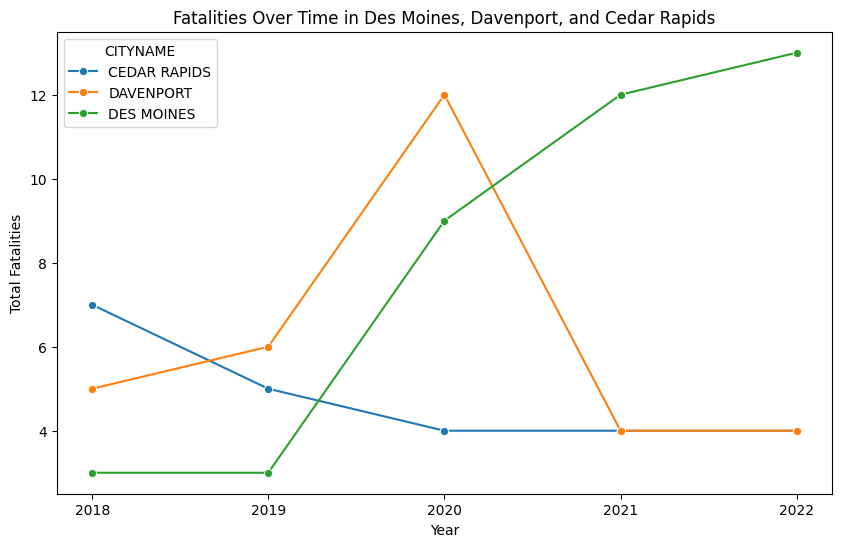

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and city, and sum the fatalities for each group
fatality_counts = final_df.groupby(['YEAR_x', 'CITYNAME'])['FATALS_x'].sum().reset_index()

# Filter for the three cities
filtered_data = fatality_counts[fatality_counts['CITYNAME'].isin(['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS'])]

# Create a lineplot showing fatalities over time for each city
plt.figure(figsize=(10,6))
sns.lineplot(data=filtered_data, x='YEAR_x', y='FATALS_x', hue='CITYNAME', marker="o")

# Set the x-axis ticks to only show full years
plt.xticks(ticks=filtered_data['YEAR_x'].unique())

plt.title('Fatalities Over Time in Des Moines, Davenport, and Cedar Rapids')
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.show()



In [ ]:
import plotly.express as px
import pandas as pd

filtered_df = final_df[
    (final_df['CITYNAME'].isin(['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS'])) &
    (final_df['YEAR_x'].between(2018, 2022))
].copy()

filtered_df = filtered_df.sort_values(by='YEAR_x')

# Create an animated scatter plot using Plotly
fig = px.scatter(
    filtered_df, x='LONGITUD', y='LATITUDE', animation_frame='YEAR_x',
    size='FATALS_x', color='CITYNAME', hover_name='CITYNAME',
    range_x=[-94.5, -90], range_y=[40, 43],  # Set map bounds to show Iowa
    title='Time-Lapse of Fatal Crashes (2018-2022)',
    size_max=10  # Set max size for fatality bubbles to avoid oversized markers
)

# Customize the layout
fig.update_layout(
    title_text='Fatal Crashes in Des Moines, Davenport, and Cedar Rapids (2018-2022)',
    xaxis_title='Longitude',
    yaxis_title='Latitude'
)

# Display the animation
fig.show()






In [ ]:
import plotly.express as px
import pandas as pd

filtered_df = final_df[
    (final_df['CITYNAME'].isin(['DES MOINES', 'DAVENPORT', 'CEDAR RAPIDS'])) &
    (final_df['YEAR_x'].between(2018, 2022))
].copy()

filtered_df = filtered_df.sort_values(by='HOUR')


# Create an animated scatter plot using Plotly
fig = px.scatter(
    filtered_df,
    x='LONGITUD',
    y='LATITUDE',
    animation_frame='HOUR',  # Change to 'HOUR' for hourly animation
    size='FATALS_x',
    color='CITYNAME',
    hover_name='CITYNAME',
    range_x=[-94.5, -90],
    range_y=[40, 43],  # Set map bounds to show Iowa
    title='Time-Lapse of Fatal Crashes by Hour (2018-2022)',
    size_max=10  # Set max size for fatality bubbles to avoid oversized markers
)

# Customize the layout
fig.update_layout(
    title_text='Fatal Crashes in Des Moines, Davenport, and Cedar Rapids by Hour (2018-2022)',
    xaxis_title='Longitude',
    yaxis_title='Latitude'
)

# Display the animation
fig.show()





To improve safety on the roads, I did a deeper investigation into the most important variables related to fatality count. I reran the random forest and disregarded the variables we couldn't hope to control (like lat/long , because no matter what we do we can't really change where  people drive).

When I look at some of the top features identified, I see that HOUR is important. We could increase police presence at later hours. We could also increase DUI checkpoints to limit drunk drivers (A_POSTBAC and DRUNK_DR). We could add more wrong way signs to reduce collisions.

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select numerical columns from the DataFrame
numerical_columns = final_df.select_dtypes(include='number').columns.tolist()

# Append any categorical variables you want to include
categorical_features = ['WEATHERNAME', 'LGT_CONDNAME', 'TYP_INTNAME', 'DAY_WEEKNAME', 'HARM_EVNAME']
features = numerical_columns + categorical_features

# Target variable
target = 'FATALS_x'

# Create a DataFrame with features only (without the target)
X = final_df[features]
X = X.drop('FATALS_x', axis=1)
X = X.drop('FATALS_y', axis=1)

# Add '00' to each feature name
X.columns = [col + '00' for col in X.columns]

# Convert categorical variables to numerical format (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Create the target variable
y = final_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_encoded.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Summing up the importance of categorical features that were split by one-hot encoding
grouped_importances = {}

# Loop through the feature names and sum importances for categorical variables
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Importance']):
    # Split feature name at '00', and take the prefix (which is the original categorical feature)
    original_feature = feature.split('00')[0]

    # Sum up importances for each categorical feature
    if original_feature in grouped_importances:
        grouped_importances[original_feature] += importance
    else:
        grouped_importances[original_feature] = importance

# Convert the grouped importances into a DataFrame for better visualization
grouped_importance_df = pd.DataFrame(list(grouped_importances.items()), columns=['Feature', 'Importance'])
grouped_importance_df = grouped_importance_df.sort_values(by='Importance', ascending=False)

top_15_importance_df = grouped_importance_df.head(15)

print("Top 15 Grouped Feature Importances:")
print(top_15_importance_df)


Mean Squared Error: 0.18885430711610487
Top 15 Grouped Feature Importances:
       Feature  Importance
7      PERSONS    0.097567
8      PERMVIT    0.064251
16        HOUR    0.055374
25    LATITUDE    0.052885
26    LONGITUD    0.051221
24      MILEPT    0.046727
67    A_POSBAC    0.043131
17      MINUTE    0.036252
1      ST_CASE    0.029808
86    DRUNK_DR    0.024235
11       MONTH    0.023692
13     DAYNAME    0.022104
12         DAY    0.020779
34    LGT_COND    0.020351
79  A_WRONGWAY    0.020294
